# Challenge

Pick a dataset of your choice with a binary outcome and the potential for at least 15 features.

Engineer your features, then create 3 models. Each model will be run on a training set and a test-set (or multiple test-sets, if you take a folds approach):

- Vanilla logistic regression
- Ridge logistic regression
- Lasso logistic regression

If you're stuck on how to begin combining your 2 new modeling skills, here's a hint: the SKlearn LogisticRegression method has a "penalty" argument that takes either 'l1' or 'l2' as a value.

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline

df = pd.read_excel('./data/ca_crimes_2013.xls', header=4, index_col="City")

# Drop any NaN 'Population' values or all-NaN columns
df = df.dropna(subset=['Population']).dropna(axis=1, how='all')

# Standardize data
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names, index=df.index)

df.head()

,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson
City,,,,,,,,,,,
Adelanto,-0.180906,-0.071458,-0.075224,0.043363,-0.105458,-0.043249,-0.183904,-0.030388,-0.226966,-0.172755,0.050807
Agoura Hills,-0.231170,-0.249871,-0.221248,-0.257374,-0.190682,-0.299822,-0.290880,-0.295664,-0.280259,-0.296063,-0.091366
Alameda,0.036716,-0.111327,-0.221248,-0.072305,-0.038497,-0.182051,0.003489,-0.122064,0.033228,0.028002,0.050807
Albany,-0.239181,-0.239904,-0.221248,-0.280508,-0.162274,-0.306131,-0.244585,-0.310293,-0.222406,-0.231861,-0.091366
Alhambra,0.077804,-0.106343,-0.148236,-0.095439,-0.046613,-0.163123,-0.020120,-0.066473,0.007864,-0.069829,-0.091366


In [2]:
def clean_data(df):
    df['Violent crime per capita'] = df['Violent\ncrime'] / df['Population']
    df['Log Violent crime'] = np.log(1 + df['Violent\ncrime'])
    df['Log Property crime'] = np.log(1 + df['Property\ncrime'])
    df['Log Population'] = np.log(1 + df['Population'])
    df['Population Sq.'] = df['Population'] ** 2
    df['Robbery Categ'] = np.where(df['Robbery'] > 0, 1, 0)
    df['Murder Categ'] = np.where(df['Murder and\nnonnegligent\nmanslaughter'] > 0, 1, 0)
    df['Assault Categ'] = np.where(df['Aggravated\nassault'] > 0, 1, 0)
    df['Rape Categ'] = np.where(df['Rape\n(legacy\ndefinition)2'] > 0, 1, 0)
    
#     df = df.drop(['Rape\n(revised\ndefinition)1'], axis=1)
    df = df[pd.notnull(df['Population'])]
    df.rename(columns = {
        'Violent\ncrime': 'Violent crime', 
        'Murder and\nnonnegligent\nmanslaughter': 'Murder', 
        'Rape\n(legacy\ndefinition)2':'Rape', 
        'Aggravated\nassault': 'Assault', 
        'Property\ncrime': 'Property crime',
        'Motor\nvehicle\ntheft': 'Vehicle theft',
        'Larceny-\ntheft': 'Larceny'
    }, inplace = True)
    
    pop_cutoff_1 = df['Population'].quantile(0.25)
    pop_cutoff_2 = df['Population'].quantile(0.75)
    
    def get_pop_tier(row):
        if row['Population'] > pop_cutoff_2:
            return 3
        elif row['Population'] > pop_cutoff_1:
            return 2
        else:
            return 1
    df['Population tier'] = [get_pop_tier(row) for i, row in df.iterrows()]
    
    df['Violent > property crimes'] = np.where(df['Violent crime'] > df['Property crime'], 1, 0)
    
    return df

df = clean_data(df)
df.head()

,Population,Violent crime,Murder,Rape,Robbery,Assault,Property crime,Burglary,Larceny,Vehicle theft,...,Log Violent crime,Log Property crime,Log Population,Population Sq.,Robbery Categ,Murder Categ,Assault Categ,Rape Categ,Population tier,Violent > property crimes
City,,,,,,,,,,,,,,,,,,,,,
Adelanto,-0.180906,-0.071458,-0.075224,0.043363,-0.105458,-0.043249,-0.183904,-0.030388,-0.226966,-0.172755,...,-0.074139,-0.203223,-0.199557,0.032727,0,0,0,1,2,1
Agoura Hills,-0.231170,-0.249871,-0.221248,-0.257374,-0.190682,-0.299822,-0.290880,-0.295664,-0.280259,-0.296063,...,-0.287510,-0.343730,-0.262885,0.053440,0,0,0,0,2,1
Alameda,0.036716,-0.111327,-0.221248,-0.072305,-0.038497,-0.182051,0.003489,-0.122064,0.033228,0.028002,...,-0.118025,0.003483,0.036058,0.001348,0,0,0,0,3,0
Albany,-0.239181,-0.239904,-0.221248,-0.280508,-0.162274,-0.306131,-0.244585,-0.310293,-0.222406,-0.231861,...,-0.274310,-0.280488,-0.273360,0.057207,0,0,0,0,2,1
Alhambra,0.077804,-0.106343,-0.148236,-0.095439,-0.046613,-0.163123,-0.020120,-0.066473,0.007864,-0.069829,...,-0.112433,-0.020325,0.074926,0.006054,0,0,0,0,3,0


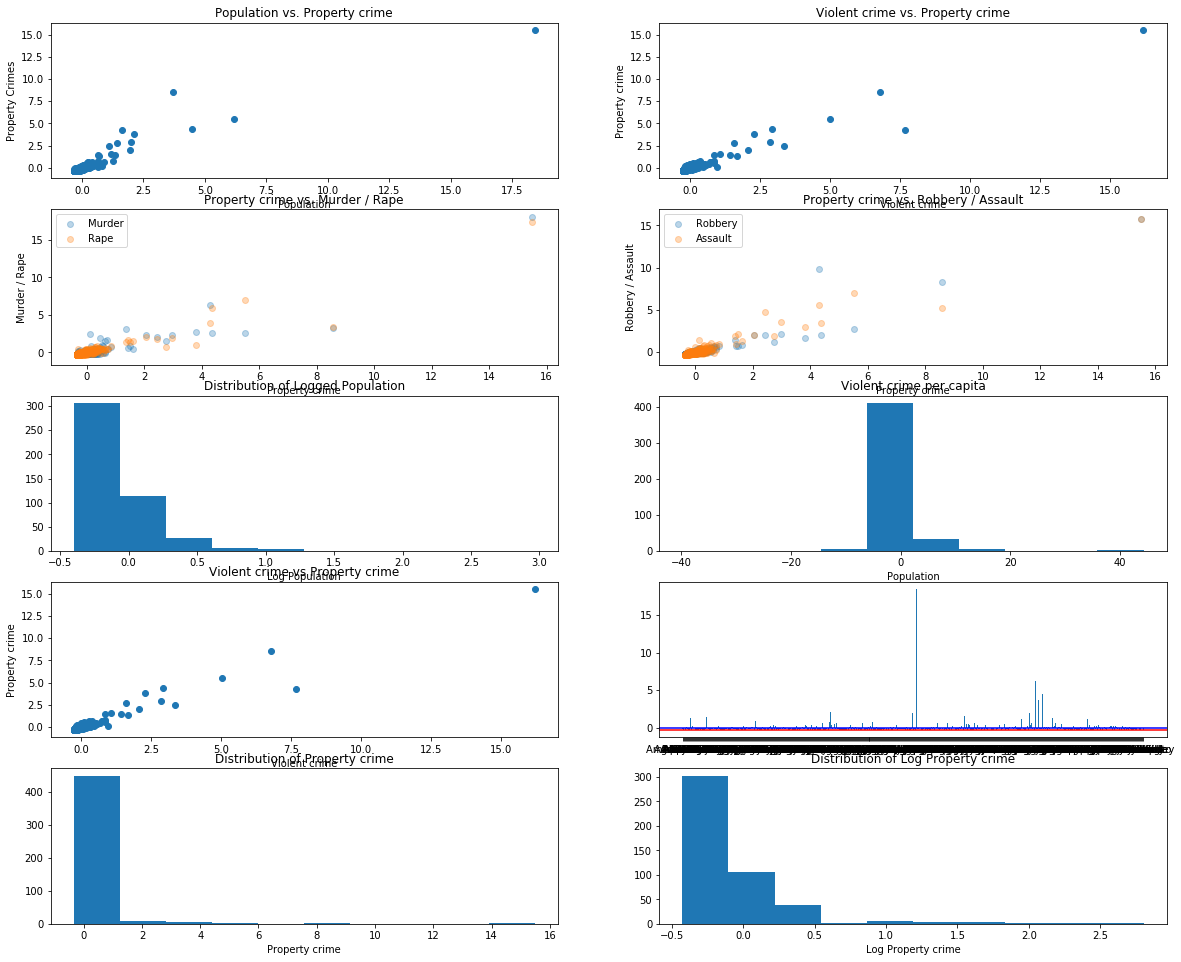

In [3]:
cities_under_outlier_cutoff = df[df['Population'] < 100000]

def display_relevant_plots(df):
    plt.figure(figsize=(20,20))

    plt.subplot(6, 2, 1)
    plt.scatter(df['Population'], df['Property crime'])
    plt.xlabel('Population')
    plt.ylabel('Property Crimes')
    plt.title('Population vs. Property crime')

    plt.subplot(6, 2, 2)
    plt.scatter(df['Violent crime'], df['Property crime'])
    plt.xlabel('Violent crime')
    plt.ylabel('Property crime')
    plt.title('Violent crime vs. Property crime')
    
    plt.subplot(6, 2, 3)
    plt.scatter(df['Property crime'], df['Murder'], alpha=0.3)
    plt.scatter(df['Property crime'], df['Rape'], alpha=0.3)
    plt.xlabel('Property crime')
    plt.ylabel('Murder / Rape')
    plt.title('Property crime vs. Murder / Rape')
    plt.legend(['Murder', 'Rape'])

    plt.subplot(6, 2, 4)
    plt.scatter(df['Property crime'], df['Robbery'], alpha=0.3)
    plt.scatter(df['Property crime'], df['Assault'], alpha=0.3)
    plt.xlabel('Property crime')
    plt.ylabel('Robbery / Assault')
    plt.title('Property crime vs. Robbery / Assault')
    plt.legend(['Robbery', 'Assault'])
    
    plt.subplot(6, 2, 5)
    plt.hist(df['Log Population'])
    plt.xlabel('Log Population')
    plt.title('Distribution of Logged Population')
    
    plt.subplot(6, 2, 6)
    plt.hist(df['Violent crime'] / df['Population'])
    plt.xlabel('Population')
    plt.title('Violent crime per capita')
    
    plt.subplot(6, 2, 7)
    plt.scatter(df['Violent crime'], df['Property crime'])
    plt.xlabel('Violent crime')
    plt.ylabel('Property crime')
    plt.title('Violent crime vs Property crime')

    plt.subplot(6, 2, 8)
    pop_cutoff_1 = df['Population'].quantile(0.25)
    pop_cutoff_2 = df['Population'].quantile(0.75)
    plt.axhline(y=pop_cutoff_1, color='r', linestyle='-')
    plt.axhline(y=pop_cutoff_2, color='b', linestyle='-')
    plt.bar(df.index, height=df['Population'])
    
    plt.subplot(6, 2, 9)
    plt.hist(df['Property crime'])
    plt.xlabel('Property crime')
    plt.title('Distribution of Property crime')
    
    plt.subplot(6, 2, 10)
    plt.hist(df['Log Property crime'])
    plt.xlabel('Log Property crime')
    plt.title('Distribution of Log Property crime')
    
    plt.show()

display_relevant_plots(cities_under_outlier_cutoff)

Lowest Crime Outlier: 0.19765747226346492
Lowest Murder Outlier: 0.21682272546652331
Lowest Rape Outlier: 0.3441003674416371
Lowest Robbery Outlier: 0.11165988194693129
Lowest Assault Outlier: 0.26589998687001676
Lowest Population Outlier: 0.4809283697165406
Lowest Log Population Outlier: 0.5330044462644528
Lowest Property Crime Outlier: 0.4562927026794524


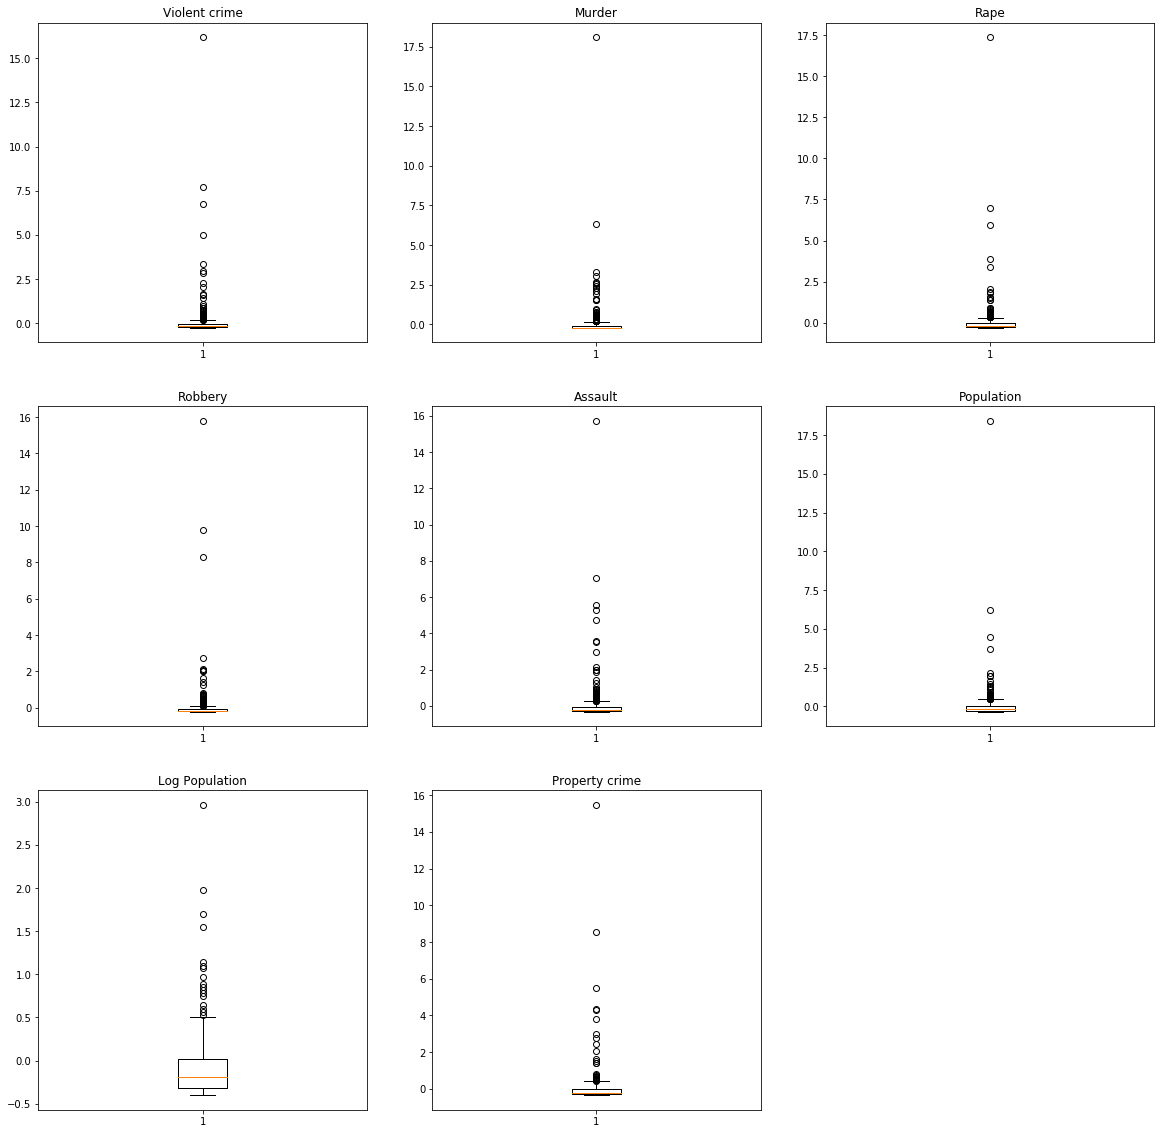

In [13]:
lowest_crime_outlier = 0
lowest_murder_outlier = 0
lowest_rape_outlier = 0
lowest_robbery_outlier = 0
lowest_assault_outlier = 0
lowest_pop_outlier = 0
lowest_pop_sq_outlier = 0

def display_boxplots(df, get_outliers):
    plt.figure(figsize=(20,20))

    plt.subplot(3, 3, 1)
    plt.title('Violent crime')
    result = plt.boxplot(df['Violent crime'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_crime_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Crime Outlier: ' + str(lowest_crime_outlier))

    plt.subplot(3, 3, 2)
    plt.title('Murder')
    result = plt.boxplot(df['Murder'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_murder_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Murder Outlier: ' + str(lowest_murder_outlier))

    plt.subplot(3, 3, 3)
    plt.title('Rape')
    result = plt.boxplot(df['Rape'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_rape_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Rape Outlier: ' + str(lowest_rape_outlier))

    plt.subplot(3, 3, 4)
    plt.title('Robbery')
    result = plt.boxplot(df['Robbery'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_robbery_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Robbery Outlier: ' + str(lowest_robbery_outlier))

    plt.subplot(3, 3, 5)
    plt.title('Assault')
    result = plt.boxplot(df['Assault'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_assault_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Assault Outlier: ' + str(lowest_assault_outlier))

    plt.subplot(3, 3, 6)
    plt.title('Population')
    result = plt.boxplot(df['Population'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_pop_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Population Outlier: ' + str(lowest_pop_outlier))

    plt.subplot(3, 3, 7)
    plt.title('Log Population')
    result = plt.boxplot(df['Log Population'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_log_pop_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Log Population Outlier: ' + str(lowest_log_pop_outlier))
    
    
    plt.subplot(3, 3, 8)
    plt.title('Property crime')
    result = plt.boxplot(df['Property crime'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_property_crime_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Property Crime Outlier: ' + str(lowest_property_crime_outlier))
        
    return {
        "violent_crime": lowest_crime_outlier,
        "murder": lowest_murder_outlier,
        "rape": lowest_rape_outlier,
        "robbery": lowest_robbery_outlier,
        "assault": lowest_assault_outlier,
        "pop": lowest_pop_outlier,
        "log_pop": lowest_log_pop_outlier,
        "property_crime": lowest_property_crime_outlier
    } if get_outliers else None

outliers = display_boxplots(df, True)

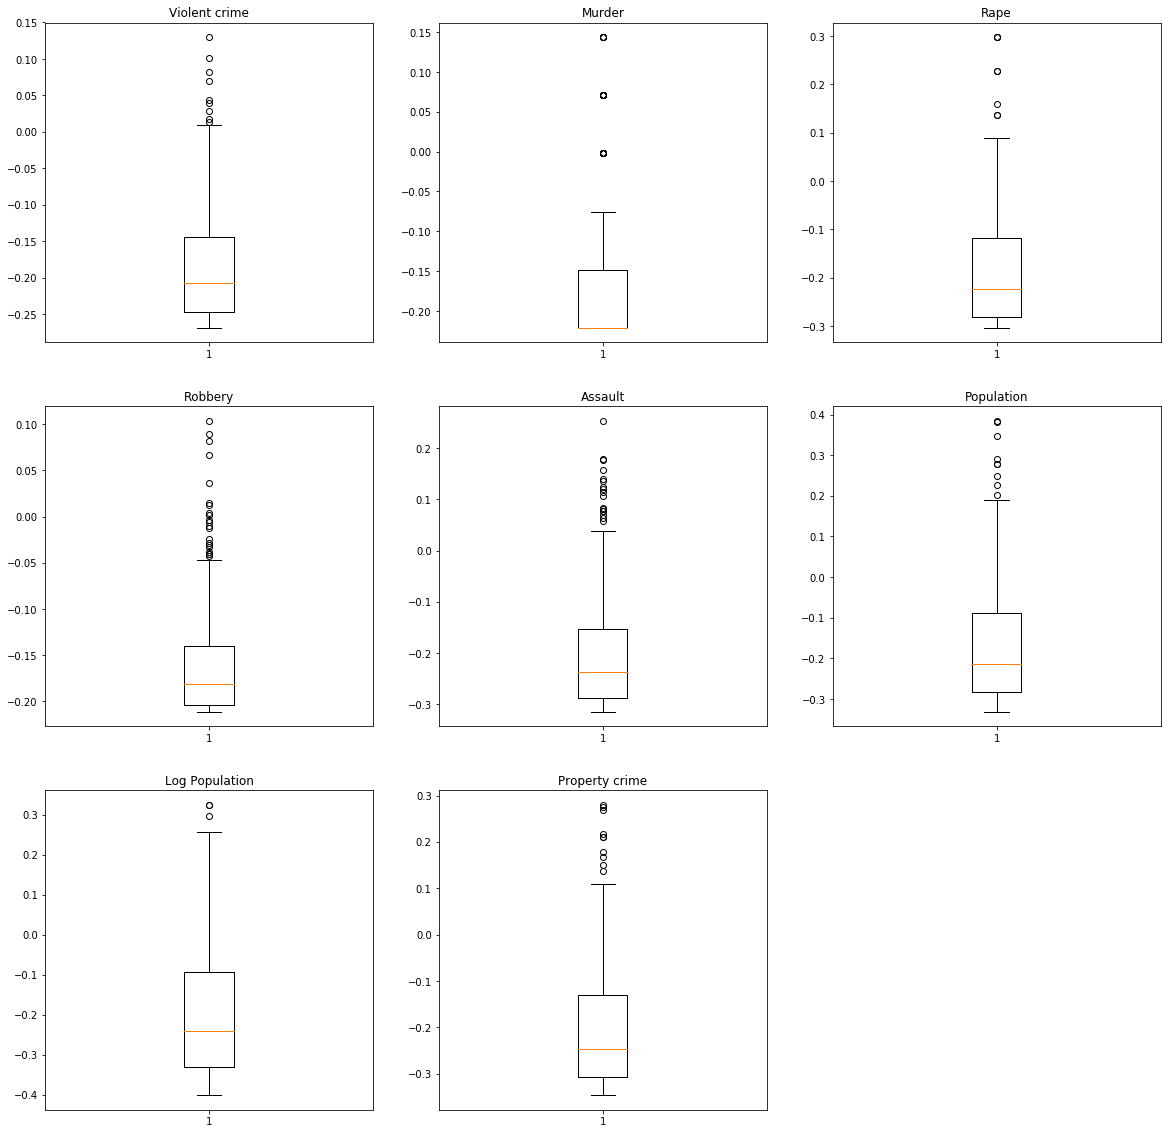

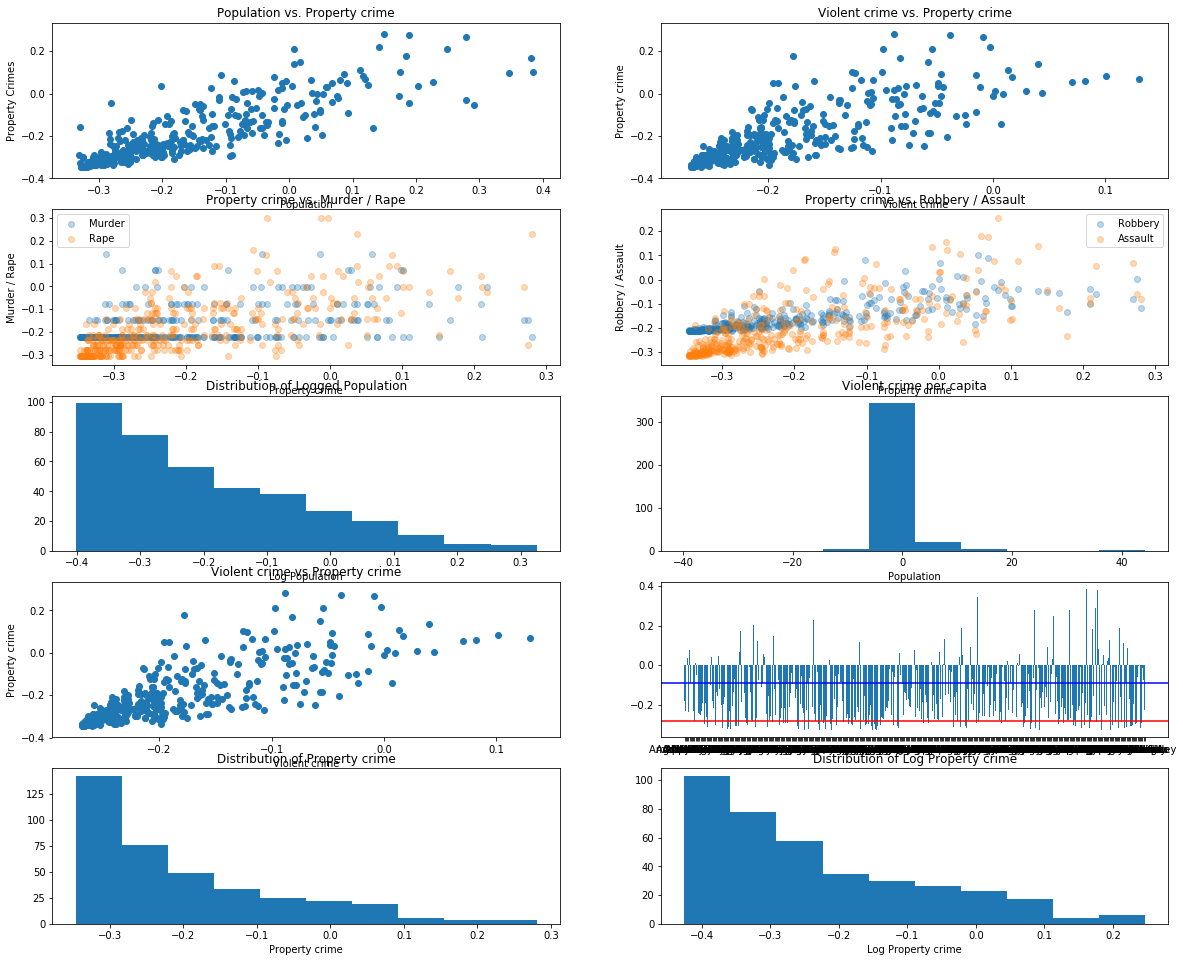

In [14]:
new_df_without_outliers = df[(df['Population'] < outliers['pop']) & (df['Violent crime'] < outliers['violent_crime']) & (df['Property crime'] < outliers['property_crime']) & (df['Murder'] < outliers['murder']) & (df['Rape'] < outliers['rape']) & (df['Robbery'] < outliers['robbery']) & (df['Assault'] < outliers['assault'])]
display_boxplots(new_df_without_outliers, False)

display_relevant_plots(new_df_without_outliers)

In [15]:
df = new_df_without_outliers

# Define training and test set sizes
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

# Define training and test sets
Y_train = df_train['Violent > property crimes'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['Violent > property crimes'])]

X_test = df_test.loc[:, ~(df_test.columns).isin(['Violent > property crimes'])]
Y_test = df_test['Violent > property crimes'].values.reshape(-1, 1)

## Vanilla Logistic Regression

In [16]:
vanilla = linear_model.LinearRegression()
vanilla.fit(X_train, Y_train)
print('\nR²:', vanilla.score(X_train, Y_train))
print('\nCoefficients:', vanilla.coef_)
print('\nIntercept:', vanilla.intercept_)


R²: 0.7704149082858025

Coefficients: [[-3.90768455e+01  5.53831725e+00 -1.93724184e-01  7.90903119e-01
   4.24104573e+00  7.22383421e+00  1.50725779e+00  6.78593613e-01
   1.86036429e+00  9.66445723e-01 -2.32456128e-01  2.18659677e-03
  -1.28961883e+01 -7.43177146e+00  3.84131049e+01  2.29379857e+01
   3.93133111e-01  1.25972850e-01 -2.49186067e-01 -1.03214308e-01
   4.64409156e-02]]

Intercept: [0.30234233]


In [17]:
print('\nR²:', vanilla.score(X_test, Y_test))


R²: 0.6618683348337706


## Ridge Logistic Regression

In [18]:
# ridge = linear_model(penalty="l2")

In [19]:
ridge = linear_model.Ridge(alpha=0.5) # fit_intercept=False
ridgefit = ridge.fit(X_train, Y_train)

print('R²:', ridge.score(X_train, Y_train))
print('\nCoefficients:', ridgefit.coef_)
print('\nIntercept:', ridgefit.intercept_)

R²: 0.7116659317654198

Coefficients: [[-0.1549635   0.32558592 -0.07344705  0.16643411 -0.1270931   0.80568456
  -0.73069348 -0.18678184 -1.08424131  0.03502643 -0.2628299  -0.00587234
   0.3011213  -1.11737913 -0.28197711  0.21563683  0.32229054  0.01516092
   0.24401218  0.12427929  0.05869909]]

Intercept: [0.0494861]


In [20]:
print('\nR²:', ridge.score(X_test, Y_test))


R²: 0.6511378089067226


## Lasso Logistic Regression

In [21]:
# lasso = linear_model(penalty="l1")

In [22]:
lasso = linear_model.Lasso(alpha=0.3)
lassofit = lasso.fit(X_train, Y_train)

print('R²:', lasso.score(X_train, Y_train))
print('\nCoefficients:', lassofit.coef_)
print('\nIntercept:', lassofit.intercept_)

R²: 0.0

Coefficients: [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.
  0. -0. -0.]

Intercept: [0.72631579]


In [23]:
print('\nR²:', lasso.score(X_test, Y_test))


R²: -0.00820512820512831


## Evaluate Models

Evaluate all 3 models and decide on your best. Be clear about the decisions you made that led to these models (feature selection, regularization parameter selection, model evaluation criteria) and why you think that particular model is the best of the three. Also reflect on the strengths and limitations of regression as a modeling approach. Were there things you couldn't do but you wish you could have done?